In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scotia
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import distance_matrix
from scipy.stats import ranksums
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")
import sys

In [3]:
datap = '/your/workspace/'
sample_l = ['wt','tet2']

In [4]:
#cell type composition in wt
sample_id ='wt'
meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
meta_df.groupby('annotation').size()

annotation
AEC              1768
Erythroid       22939
Erythroidpro     5743
Hepatocyte       6438
MK                956
Macrophage       1335
Myeloid           854
SEC               778
Unknown            53
dtype: int64

In [5]:
#cell type composition in mut
sample_id ='tet2'
meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
meta_df.groupby(['annotation']).size()

annotation
AEC               662
Erythroid       28265
Erythroidpro    11708
Hepatocyte       7636
MK                746
Macrophage        647
Myeloid          1306
SEC              4000
dtype: int64

In [7]:
#get DBSCAN cell clusters
for sample_id in ['tet2']:
    print(sample_id)
    meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
    #for fov in set(meta_df['fov']):
    for fov in [9]:
        print(fov)
        celltype = []
        cell_idx = []
        meta_df_fov = meta_df[meta_df['fov']==fov]
        meta_df_fov['index'] = range(meta_df_fov.shape[0])

        cell_type_l = list(set(meta_df_fov['annotation']))
        for ct in cell_type_l:
            print(ct)
            meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
            X = np.array(meta_df_sel[['x_pos','y_pos']])
            if X.shape[0] >= 10:
                print(ct)
                idx_l, fi_eps = scotia.dbscan_ff_cell(X, X_index_arr=np.array(meta_df_sel['index']),eps_l = list(range(10,50,1)))
                if len(idx_l)>0:
                    celltype += [ct for x in idx_l]
                    cell_idx += idx_l
        tmp_df = pd.DataFrame([celltype,cell_idx]).T
        np.save(datap+'output/clustering/'+sample_id+'_fov_'+str(fov)+'_dbscan.cell.clusters.test',tmp_df)

tet2
9
Erythroid
Erythroid
eps: 17
AEC
Macrophage
Erythroidpro
Erythroidpro
eps: 24
SEC
SEC
eps: 35
MK
Myeloid
Hepatocyte
Hepatocyte
eps: 28


tet2
Erythroid


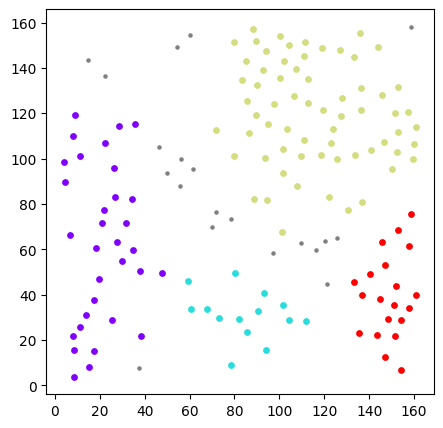

Erythroidpro


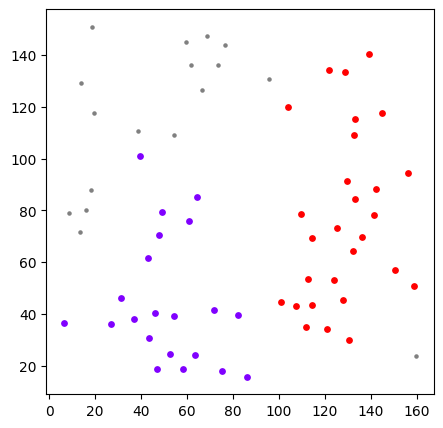

SEC


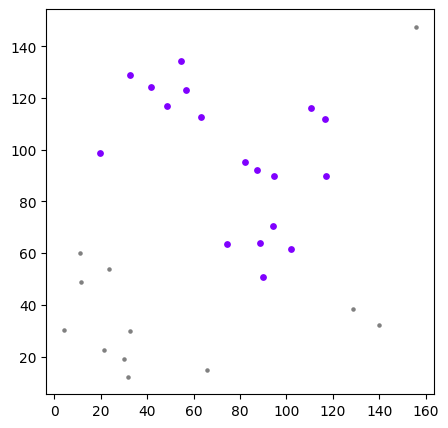

Hepatocyte


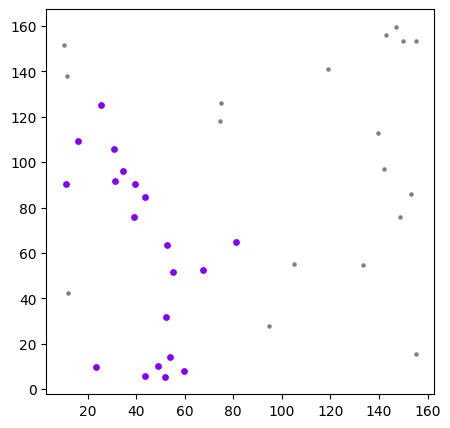

In [8]:
#visualization of DBSCAN clustering result
#legend: each dot is a cell, cells of the same color are from the same cluster, cells in the grey color are the noise identified by DBSCAN
#for fov in set(meta_df['fov']):
for sample_id in ['tet2']:
    print(sample_id)
    meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
    #for fov in set(meta_df['fov']):
    for fov in [9]:
        cluster_df = pd.DataFrame(np.load(datap+'output/clustering/'+sample_id+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
        cluster_df.columns = ['cell_type','cell_idx']

        meta_df_fov = meta_df[meta_df['fov']==fov]
        meta_df_fov.index = range(meta_df_fov.shape[0])
        cell_type_l = list(set(cluster_df['cell_type']))
        for ct in cell_type_l:
            print(ct)
            plt.figure(figsize=(5,5))
            #plot all ct cells
            #higlight clusters for ct cells
            tmp_ct = cluster_df[cluster_df['cell_type']==ct]
            colors = cm.rainbow(np.linspace(0, 1, tmp_ct.shape[0]))
            if tmp_ct.shape[0]>0:
                meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
                X_sel = np.array(meta_df_sel[['x_pos','y_pos']])
                plt.scatter(X_sel[:,0],X_sel[:,1],c = 'grey',s = 5)

                for n,line in enumerate(tmp_ct['cell_idx']):
                    X = np.array(meta_df_fov.loc[line][['x_pos','y_pos']])
                    plt.scatter(X[:,0],X[:,1],color =colors[n],s = 15)
                #plt.savefig(datap+'example/output/Figs/'+group+'_fov_'+str(fov)+"_"+ct+".cluster.pdf", dpi=100, tansparent=True)
                plt.show()

In [100]:
#ot
exp_df_all = pd.read_csv(datap+'data/wt_mut_exp_matrix.txt',sep='\t',index_col=None)
exp_df_norm = exp_df_all.iloc[:,2:]
exp_df_norm = exp_df_norm[exp_df_norm>0]
df_quantile = exp_df_norm.quantile(q=0.99,axis = 0) 
known_lr_pairs = pd.read_csv(datap+'/data/lr_gene.list', header = None, index_col = None, sep = '\t')
known_lr_pairs.columns = ['l_gene','r_gene']

for sample_id in ['wt']:
    print(sample_id)
    meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
    #for fov in set(meta_df['fov']):
    for fov in [0]:
        #clustering result
        cluster_df = pd.DataFrame(np.load(datap+'output/clustering/'+sample_id+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
        cluster_df.columns = ['cell_type','cell_idx']

        #coordinates
        meta_df_fov = meta_df[meta_df['fov']==fov]
        meta_df_fov.index = range(meta_df_fov.shape[0])
        cell_id_all = np.array(range(meta_df_fov.shape[0]))
        coord = np.array(meta_df_fov[['x_pos','y_pos']])
        S_all_arr = distance_matrix(coord,coord)

        #expression
        exp_df_fov = meta_df_fov.iloc[:,6:]
        exp_df_fov = exp_df_fov/df_quantile
        exp_df_fov[exp_df_fov>1]=1
        exp_df_fov.index = cell_id_all

        #select potentially communicating cell cluster pairs (spatially adjacent)
        S_all_arr_new = scotia.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)

        #optimal transport between source and target cells
        ga_df_final = scotia.source_target_ot(S_all_arr_new, exp_df_fov, meta_df_fov, known_lr_pairs)
        if ga_df_final.shape[0]>0:
            ga_df_final.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
            ga_df_final.to_csv(datap+'output/ot/'+sample_id+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")

            #post-processing of ot results by calculating averaged likelihoods
            ga_df_final['cell_pairs'] = ga_df_final['source_cell_type']+"_"+ga_df_final['target_cell_type']
            final_summary = scotia.post_ot(ga_df_final,label=sample_id)
            final_summary.to_csv(datap+'output/ot/summary/'+sample_id+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")



wt


In [51]:
#prepare shuffled data for permutation test
it_n = 50
for sample_id in ['wt','tet2']:
    print(sample_id)
    meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
    for fov in set(meta_df['fov']):
    #for fov in [9]:
        #print(fov)
      
        #coordinates
        meta_df_fov = meta_df[meta_df['fov']==fov]
        meta_df_fov.index = range(meta_df_fov.shape[0])
        cell_id_all = np.array(range(meta_df_fov.shape[0]))
        coord = np.array(meta_df_fov[['x_pos','y_pos']])
        S_all_arr = distance_matrix(coord,coord)

        #get permutated positions and expression
        random_pos, shuffled_exp = scotia.permutation_test(coord,int(it_n))
        #random_pos.to_csv(datap+'output/permutation/'+sample_id+"_"+str(fov)+'_shuffled_pos.csv')
        #shuffled_exp.to_csv(datap+'output/permutation/'+sample_id+"_"+str(fov)+'_shuffled_exp.csv',)

wt
tet2


In [96]:
#permutation test
exp_df_all = pd.read_csv(datap+'data/wt_mut_exp_matrix.txt',sep='\t',index_col=None)
exp_df_norm = exp_df_all.iloc[:,2:]
exp_df_norm = exp_df_norm[exp_df_norm>0]
df_quantile = exp_df_norm.quantile(q=0.99,axis = 0) 
known_lr_pairs = pd.read_csv(datap+'/data/lr_gene.list', header = None, index_col = None, sep = '\t')
known_lr_pairs.columns = ['l_gene','r_gene']

it_n = 50
for sample_id in ['tet2']:
    print(sample_id)
    meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
    #for fov in set(meta_df['fov']):
    for fov in [9]:
        #print(fov)
        #cluster
        cluster_df = pd.DataFrame(np.load(datap+'/output/clustering/'+sample_id+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
        cluster_df.columns = ['cell_type','cell_idx']

        #coordinates
        meta_df_fov = meta_df[meta_df['fov']==fov]
        meta_df_fov.index = range(meta_df_fov.shape[0])
        cell_id_all = np.array(range(meta_df_fov.shape[0]))
        coord = np.array(meta_df_fov[['x_pos','y_pos']])
        S_all_arr = distance_matrix(coord,coord)

        #expression
        exp_df_fov = meta_df_fov.iloc[:,6:]
        exp_df_fov = exp_df_fov/df_quantile
        exp_df_fov[exp_df_fov>1] = 1
        exp_df_fov.index = cell_id_all

        #get permutated positions and expression
        random_pos = pd.read_csv(datap+'output/permutation/'+sample_id+"_"+str(fov)+'_shuffled_pos.csv',index_col=0)
        shuffled_exp = pd.read_csv(datap+'output/permutation/'+sample_id+"_"+str(fov)+'_shuffled_exp.csv',index_col=0)

        #select potentially communicating cell cluster pairs (spatially adjacent)
        S_all_arr_new = scotia.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)

        final_summary = pd.DataFrame([])
        for i_n in range(int(it_n)):
            exp_df_permu = exp_df_fov.loc[list(shuffled_exp.iloc[:,i_n])]
            coord_permu = np.array(random_pos.iloc[:,i_n*2:i_n*2+2])
            S_all_arr_permu = distance_matrix(coord_permu,coord_permu)
            mask = np.where(S_all_arr_new==np.inf)
            S_all_arr_permu[mask] = np.inf
            S_all_arr_permu = S_all_arr_permu

            #optimal transport
            ga_df_permu = scotia.source_target_ot(S_all_arr_permu, exp_df_permu, meta_df_fov, known_lr_pairs)

            if ga_df_permu.shape[0]>0:
                ga_df_permu.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
                ga_df_permu.to_csv(datap+'output/permutation/'+sample_id+'_fov_'+str(fov)+".permu.csv",header = True, index = False, sep = "\t")


                #post-processing ot results by calculating averaged likelihoods
                ga_df_permu['cell_pairs'] = ga_df_permu['source_cell_type']+"_"+ga_df_permu['target_cell_type']
                final_summary_tmp = scotia.post_ot(ga_df_permu, label=sample_id, it_n_label = i_n)
                final_summary = pd.concat([final_summary,final_summary_tmp])

        final_summary.to_csv(datap+'output/permutation/summary/'+sample_id+'_fov_'+str(fov)+".permu.csv",header = True, index = False, sep = "\t")


tet2


In [9]:
sample_id = 'tet2'
df_ot = pd.read_csv(datap+'output/ot/summary/'+sample_id+'_all_ori.csv',header = None, index_col = None, sep = '\t')
df_ot.columns = ['label','likelihood']
df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]
df_ot['ct1'] = [x.split('_')[0] for x in df_ot['cell_pairs']]
df_ot['ct2'] = [x.split('_')[1] for x in df_ot['cell_pairs']]
df_ot = df_ot[df_ot['ct1']!=df_ot['ct2']]
tmp_size = df_ot.groupby('label')['likelihood'].size()
tmp_size = tmp_size[tmp_size>10].reset_index()
tmp1 = df_ot.groupby('label')['likelihood'].median().reset_index()
tmp1 = tmp1[tmp1['label'].isin(tmp_size['label'])]
tmp1['lr_pairs'] = [x.split('|')[0] for x in tmp1['label']]
tmp1['cell_pairs'] = [x.split('|')[2] for x in tmp1['label']]
tmp2 = tmp1[tmp1['lr_pairs']=='Kitl_Kit'].sort_values("likelihood",ascending=False)
tmp2

,label,likelihood,lr_pairs,cell_pairs
543,Kitl_Kit|tet2|Hepatocyte_Erythroidpro,0.206750,Kitl_Kit,Hepatocyte_Erythroidpro
532,Kitl_Kit|tet2|Erythroid_Erythroidpro,0.172670,Kitl_Kit,Erythroid_Erythroidpro
551,Kitl_Kit|tet2|SEC_Erythroidpro,0.164574,Kitl_Kit,SEC_Erythroidpro
542,Kitl_Kit|tet2|Hepatocyte_Erythroid,0.097807,Kitl_Kit,Hepatocyte_Erythroid
537,Kitl_Kit|tet2|Erythroidpro_Erythroid,0.086366,Kitl_Kit,Erythroidpro_Erythroid
550,Kitl_Kit|tet2|SEC_Erythroid,0.074597,Kitl_Kit,SEC_Erythroid
540,Kitl_Kit|tet2|Erythroidpro_SEC,0.072059,Kitl_Kit,Erythroidpro_SEC
538,Kitl_Kit|tet2|Erythroidpro_Hepatocyte,0.064877,Kitl_Kit,Erythroidpro_Hepatocyte
533,Kitl_Kit|tet2|Erythroid_Hepatocyte,0.058276,Kitl_Kit,Erythroid_Hepatocyte
545,Kitl_Kit|tet2|Hepatocyte_SEC,0.056438,Kitl_Kit,Hepatocyte_SEC


In [11]:
df_ot_sel = df_ot[df_ot['label'].isin(tmp2['label'])]
df_ot_sel

,label,likelihood,lr_pairs,cell_pairs,ct1,ct2
3,Kitl_Kit|tet2|Hepatocyte_Erythroidpro,0.370258,Kitl_Kit,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
14,Kitl_Kit|tet2|Erythroidpro_Erythroid,0.134695,Kitl_Kit,Erythroidpro_Erythroid,Erythroidpro,Erythroid
55,Kitl_Kit|tet2|Erythroidpro_Hepatocyte,0.067084,Kitl_Kit,Erythroidpro_Hepatocyte,Erythroidpro,Hepatocyte
67,Kitl_Kit|tet2|Erythroid_Erythroidpro,0.231281,Kitl_Kit,Erythroid_Erythroidpro,Erythroid,Erythroidpro
84,Kitl_Kit|tet2|Hepatocyte_Erythroid,0.137495,Kitl_Kit,Hepatocyte_Erythroid,Hepatocyte,Erythroid
...,...,...,...,...,...,...
16408,Kitl_Kit|tet2|Erythroid_Hepatocyte,0.180289,Kitl_Kit,Erythroid_Hepatocyte,Erythroid,Hepatocyte
16416,Kitl_Kit|tet2|SEC_Hepatocyte,0.031796,Kitl_Kit,SEC_Hepatocyte,SEC,Hepatocyte
16424,Kitl_Kit|tet2|SEC_Erythroidpro,0.143791,Kitl_Kit,SEC_Erythroidpro,SEC,Erythroidpro
16437,Kitl_Kit|tet2|Erythroid_SEC,0.057171,Kitl_Kit,Erythroid_SEC,Erythroid,SEC


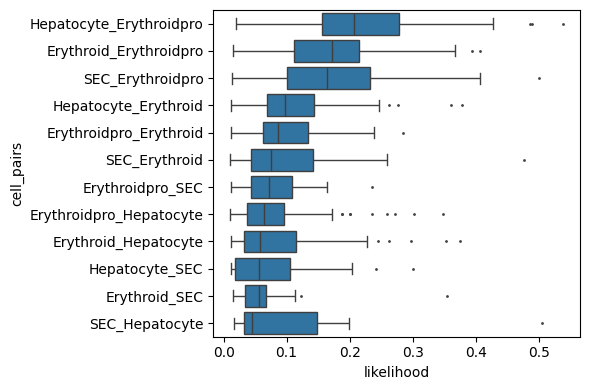

In [12]:
plt.figure(figsize=(6,4))
plt.ylim([-0.05,0.6])
ax1 = sns.boxplot(x='likelihood',y='cell_pairs',data=df_ot_sel,order=list(tmp2['cell_pairs']),fliersize=1)
plt.tight_layout()
plt.savefig(datap+'output/Figs/tet2_all_cell_pairs.png',dpi=300)


In [14]:
sample_id = 'tet2'
df_ot = pd.read_csv(datap+'output/ot/summary/'+sample_id+'_all_ori.csv',header = None, index_col = None, sep = '\t')
df_ot.columns = ['label','likelihood']
df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]
df_ot['ct1'] = [x.split('_')[0] for x in df_ot['cell_pairs']]
df_ot['ct2'] = [x.split('_')[1] for x in df_ot['cell_pairs']]
df_ot = df_ot[df_ot['ct1']!=df_ot['ct2']]
tmp_size = df_ot.groupby('label')['likelihood'].size()
tmp_size = tmp_size[tmp_size>10].reset_index()
tmp1 = df_ot.groupby('label')['likelihood'].median().reset_index()
tmp1 = tmp1[tmp1['label'].isin(tmp_size['label'])]
tmp1['lr_pairs'] = [x.split('|')[0] for x in tmp1['label']]
tmp1['cell_pairs'] = [x.split('|')[2] for x in tmp1['label']]
tmp2 = tmp1[tmp1['cell_pairs']=='Hepatocyte_Erythroidpro'].sort_values("likelihood",ascending=False)
tmp2

,label,likelihood,lr_pairs,cell_pairs
543,Kitl_Kit|tet2|Hepatocyte_Erythroidpro,0.206750,Kitl_Kit,Hepatocyte_Erythroidpro
135,Dll1_Notch2|tet2|Hepatocyte_Erythroidpro,0.142541,Dll1_Notch2,Hepatocyte_Erythroidpro
464,Jag2_Notch2|tet2|Hepatocyte_Erythroidpro,0.131917,Jag2_Notch2,Hepatocyte_Erythroidpro
353,Jag1_Notch2|tet2|Hepatocyte_Erythroidpro,0.095897,Jag1_Notch2,Hepatocyte_Erythroidpro
493,Jag2_Notch3|tet2|Hepatocyte_Erythroidpro,0.094106,Jag2_Notch3,Hepatocyte_Erythroidpro
384,Jag1_Notch3|tet2|Hepatocyte_Erythroidpro,0.093026,Jag1_Notch3,Hepatocyte_Erythroidpro
158,Dll1_Notch3|tet2|Hepatocyte_Erythroidpro,0.089832,Dll1_Notch3,Hepatocyte_Erythroidpro
290,Efnb2_Ephb4|tet2|Hepatocyte_Erythroidpro,0.088054,Efnb2_Ephb4,Hepatocyte_Erythroidpro
113,Dll1_Notch1|tet2|Hepatocyte_Erythroidpro,0.080546,Dll1_Notch1,Hepatocyte_Erythroidpro
14,Angpt1_Tek|tet2|Hepatocyte_Erythroidpro,0.078343,Angpt1_Tek,Hepatocyte_Erythroidpro


In [15]:
df_ot_sel = df_ot[df_ot['label'].isin(tmp2['label'])]
df_ot_sel

,label,likelihood,lr_pairs,cell_pairs,ct1,ct2
0,Dll1_Notch2|tet2|Hepatocyte_Erythroidpro,0.160572,Dll1_Notch2,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
1,Jag2_Notch1|tet2|Hepatocyte_Erythroidpro,0.073060,Jag2_Notch1,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
2,Jag1_Notch2|tet2|Hepatocyte_Erythroidpro,0.118003,Jag1_Notch2,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
3,Kitl_Kit|tet2|Hepatocyte_Erythroidpro,0.370258,Kitl_Kit,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
4,Jag2_Notch2|tet2|Hepatocyte_Erythroidpro,0.068803,Jag2_Notch2,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
...,...,...,...,...,...,...
16374,Dll4_Notch3|tet2|Hepatocyte_Erythroidpro,0.019757,Dll4_Notch3,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
16375,Dll4_Notch4|tet2|Hepatocyte_Erythroidpro,0.038460,Dll4_Notch4,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
16376,Dll1_Notch2|tet2|Hepatocyte_Erythroidpro,0.059496,Dll1_Notch2,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro
16377,Jag1_Notch4|tet2|Hepatocyte_Erythroidpro,0.011919,Jag1_Notch4,Hepatocyte_Erythroidpro,Hepatocyte,Erythroidpro


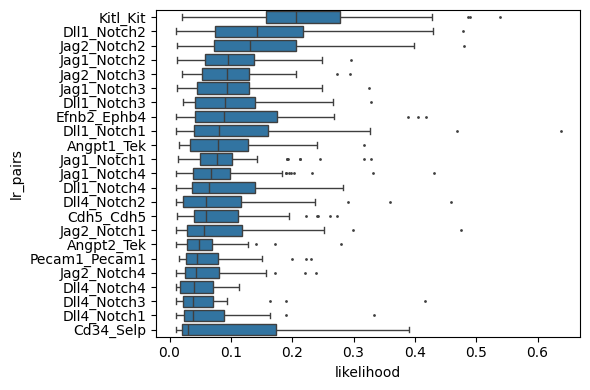

In [16]:
plt.figure(figsize=(6,4))
plt.ylim([-0.05,0.6])
ax1 = sns.boxplot(x='likelihood',y='lr_pairs',data=df_ot_sel,order=list(tmp2['lr_pairs']),fliersize=1)
plt.tight_layout()
plt.savefig(datap+'output/Figs/tet2_Hepatocyte_Erythroidpro_all_lr_pairs.pdf')


# permutation 

In [17]:
def read_data(file):
    try:
        df = pd.read_csv(file, header = 0, index_col=None, sep = "\t")
    except:
        df = pd.DataFrame()
    return df

In [18]:
it_n = 50
#group = 'wt'
group = 'mut'
c_t_1 = 'Hepatocyte'
c_t_2 = 'Erythroidpro'


df_ot = pd.DataFrame([])
df_permu = pd.DataFrame([])

compare_dic ={}
for fov in range(it_n):
    
    #import ot result
    df_ot_tmp = read_data(datap+'output/ot/'+sample_id+'_fov_'+str(fov)+'.ot.csv')#final 
    
    if df_ot_tmp.shape[0]>0:
        df_ot = pd.concat([df_ot,df_ot_tmp])
    
    #import permutation result
    df_permu_tmp = read_data(datap+'output/permutation/'+sample_id+'_fov_'+str(fov)+'.permu.csv')
    if df_permu_tmp.shape[0]>0:
        df_permu = pd.concat([df_permu,df_permu_tmp])

In [19]:
df_permu

,source_cell_idx,receptor_cell_idx,likelihood,ligand_recptor,source_cell_type,target_cell_type
0,43,70,0.047757,Angpt1_Tek,Erythroidpro,Erythroid
1,98,97,0.197338,Angpt1_Tek,Erythroidpro,SEC
2,127,140,0.080121,Angpt1_Tek,Erythroidpro,Erythroid
3,261,274,0.197599,Angpt1_Tek,Erythroid,Erythroidpro
4,286,247,0.035746,Angpt1_Tek,Erythroid,Erythroidpro
...,...,...,...,...,...,...
194,229,176,0.025962,Pecam1_Pecam1,Erythroidpro,Erythroid
195,260,272,0.194774,Pecam1_Pecam1,Erythroid,Erythroidpro
196,260,304,0.038097,Pecam1_Pecam1,Erythroid,Erythroidpro
197,272,260,0.194774,Pecam1_Pecam1,Erythroidpro,Erythroid


In [20]:
it_n = 50
sample_id = 'tet2'
c_t_1 = 'Hepatocyte'
c_t_2 = 'Erythroidpro'


df_ot = pd.DataFrame([])
df_permu = pd.DataFrame([])

compare_dic ={}

meta_df = pd.read_csv(datap+'/data/'+sample_id+'_anno.csv',sep = '\t',header = 0,index_col = None)
for fov in set(meta_df['fov']):
#for fov in [9]:
    #import ot result
    df_ot_tmp = read_data(datap+'output/ot/summary/'+sample_id+'_fov_'+str(fov)+'.ot.csv')#final 
    
    if df_ot_tmp.shape[0]>0:
        df_ot = pd.concat([df_ot,df_ot_tmp])
    
    #import permutation result
    df_permu_tmp = read_data(datap+'output/permutation/summary/'+sample_id+'_fov_'+str(fov)+'.permu.csv')
    if df_permu_tmp.shape[0]>0:
        df_permu = pd.concat([df_permu,df_permu_tmp])
        
df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]  

df_permu['it_n'] = [x.split('|')[-1] for x in df_permu['label']]
df_permu['lr_pairs'] = [x.split('|')[0] for x in df_permu['label']]
df_permu['label_new'] = df_permu['lr_pairs']+"|"+df_permu['it_n'].map(str)
df_permu['cell_pairs'] = [x.split('|')[2] for x in df_permu['label']]


c_t_p = c_t_1+"_"+c_t_2
df_ot_tmp = df_ot[df_ot['cell_pairs'] == c_t_p]
df_permu_tmp = df_permu[df_permu['cell_pairs'] == c_t_p]

if df_permu_tmp.shape[0]>0:
    df_ot_groupby = df_ot_tmp.groupby(['label'])['ave_likelihood'].sum().to_frame().reset_index()
    df_ot_groupby.index = [x.split('|')[0] for x in df_ot_groupby['label']]
    df_permu_groupby = df_permu_tmp.groupby(['label_new'])['ave_likelihood'].sum()

    for i in df_ot_groupby.index:
        compare_dic[i+"|"+group+"|"+c_t_p] = 0
        df_permu_groupby_sel = df_permu_groupby[df_permu_groupby.index.str.contains(i+"\|")]
        for j in df_permu_groupby_sel:
            if j > df_ot_groupby.loc[i,'ave_likelihood']:
                compare_dic[i+"|"+group+"|"+c_t_p] += 1/it_n
                        
p_l = [round(x,3) for x in compare_dic.values()]
pvalue_adj = multipletests(p_l, alpha=0.05, method='fdr_bh')[1]
pvalue_adj = [round(x,3) for x in pvalue_adj]

In [21]:
compare_dic

{'Angpt1_Tek|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Angpt2_Tek|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Cd34_Selp|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Cdh5_Cdh5|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Dll1_Notch1|mut|Hepatocyte_Erythroidpro': 0.9800000000000005,
 'Dll1_Notch2|mut|Hepatocyte_Erythroidpro': 0,
 'Dll1_Notch3|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Dll1_Notch4|mut|Hepatocyte_Erythroidpro': 0.9800000000000005,
 'Dll4_Notch1|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Dll4_Notch2|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Dll4_Notch3|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Dll4_Notch4|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Efnb2_Ephb4|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Jag1_Notch1|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Jag1_Notch2|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,
 'Jag1_Notch3|mut|Hepatocyte_Erythroidpro': 1.0000000000000004,

In [278]:
###########permutation all summary, generate output for circleplot
it_n = 50
for sample_id in ['tet2']:
    print(sample_id)
    sig_ratio_dic = {}
    sig_num_dic = {}
    sig_weight_dic = {}
    sig_gene_l = {}
    
    df_ot = pd.read_csv(datap+'output/ot/summary/'+sample_id+'_all_ori.csv',header = None, index_col = None, sep = '\t')
    
    df_ot.columns = ['label','likelihood']
    df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
    df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]
    #import permut
    df_permu = pd.read_csv(datap+'output/permutation/summary/'+sample_id+"_all_shuffle.csv",header = None, index_col = None,sep='\t')
    
    df_permu.columns = ['label','likelihood']
    df_permu['it_n'] = [x.split('|')[-1] for x in df_permu['label']]
    df_permu['lr_pairs'] = [x.split('|')[0] for x in df_permu['label']]
    df_permu['label_new'] = df_permu['lr_pairs']+"|"+df_permu['it_n'].map(str)
    df_permu['cell_pairs'] = [x.split('|')[2] for x in df_permu['label']]

    for c_t_p in set(df_ot['cell_pairs']):
        compare_dic ={}
        df_ot_tmp = df_ot[df_ot['cell_pairs'] == c_t_p]
        df_permu_tmp = df_permu[df_permu['cell_pairs'] == c_t_p]

        if df_permu_tmp.shape[0]>0:

            df_ot_groupby = df_ot_tmp.groupby(['label'])['likelihood'].sum().to_frame().reset_index()
            df_ot_groupby.index = [x.split('|')[0] for x in df_ot_groupby['label']]
            df_permu_groupby = df_permu_tmp.groupby(['label_new'])['likelihood'].sum()

            for i in df_ot_groupby.index:
                compare_dic[i+"|"+sample_id+"|"+c_t_p] = 0
                df_permu_groupby_sel = df_permu_groupby[df_permu_groupby.index.str.contains(i+"\|")]
                for j in df_permu_groupby_sel:
                    if j > df_ot_groupby.loc[i,'likelihood']:
                        compare_dic[i+"|"+sample_id+"|"+c_t_p] += 1/it_n

            sum_df = pd.DataFrame({'label': compare_dic.keys(),'pvalue': compare_dic.values()})
            sum_df['sample_id'] = [x.split("|")[1] for x in sum_df['label']]
            sum_df['lr_pairs'] =  [x.split("|")[0] for x in sum_df['label']]

            pvalues_sig = [x for x in sum_df['pvalue'] if x <0.05]
            sig_num_dic[c_t_p] = len(pvalues_sig)

            sig_id = list(sum_df[sum_df['pvalue']<0.05]['lr_pairs']+"|"+sample_id+"|"+c_t_p)
            df_ot_groupby_new =  df_ot.groupby(['label'])['likelihood'].quantile(q=0.9).to_frame()
            #df_ot_groupby_new =  df_ot.groupby(['label'])['likelihood'].sum().to_frame()
            sum_likelihood = df_ot_groupby_new.loc[sig_id]['likelihood'].mean()
            sig_weight_dic[c_t_p] = sum_likelihood

            sig_gene_l[c_t_p]=list(sum_df[sum_df['pvalue']<0.05]['lr_pairs'])


        else:
            sig_weight_dic[c_t_p] = 0
            sig_gene_l[c_t_p]= []
            sig_num_dic[c_t_p] = 0           
    with open(datap+'output/permutation/summary/'+sample_id+'_sig_permu_likeli_mean.txt','w') as f1:
        for k,v in sig_weight_dic.items():
            f1.write(k+"\t"+str(round(v,2))+'\n')
    with open(datap+'output/permutation/summary/'+sample_id+'_sig_permu_number.txt','w') as f1:
        for k,v in sig_num_dic.items():
            f1.write(k+"\t"+str(round(v,2))+'\n')


tet2


In [38]:
df_ratio = pd.DataFrame([])
for sample_id in sample_l:
#for sample_id in ['2626']:
    print(sample_id)
    df_ratio_tmp = pd.read_csv(datap+'output/permutation/summary/'+sample_id+'_sig_permu_number.txt',sep = '\t',header=None, index_col = None)
    df_ratio_tmp.columns = ['lr_pairs','sig_number']
    df_weight = pd.read_csv(datap+'output/permutation/summary/'+sample_id+'_sig_permu_likeli_mean.txt',sep = '\t',header=None, index_col = None)
    
    
    df_weight.columns = ['lr_pairs','ave_weight']
    df_ratio_tmp = df_ratio_tmp.merge(df_weight)
    df_ratio_tmp['sum'] = df_ratio_tmp['sig_number']*df_ratio_tmp['ave_weight']
    df_ratio_tmp['sample_id'] = sample_id
    df_ratio = pd.concat([df_ratio,df_ratio_tmp])
    df_ratio = df_ratio[df_ratio['sample_id']!='2462']
    df_ratio = df_ratio[~df_ratio['lr_pairs'].str.contains('Noise')]
    df_ratio = df_ratio[~df_ratio['lr_pairs'].str.contains('ductal')]

wt
tet2


In [39]:
df_exp=pd.pivot(df_ratio[['lr_pairs','sum','sample_id']],index='lr_pairs',columns = 'sample_id')
df_exp.columns = df_exp.columns.get_level_values(1)
df_exp.columns.name = ''
df_exp.index.name = ''
df_exp[np.isnan(df_exp)==True]=0

df_per=pd.pivot(df_ratio[['lr_pairs','sum','sample_id']],index='lr_pairs',columns = 'sample_id')
df_per.columns = df_per.columns.get_level_values(1)
df_per.columns.name = ''
df_per[np.isnan(df_per)==True]=0

In [40]:
df_per['mean_u'] = np.mean(df_per[['wt']],axis =1)
df_per['mean_t'] = np.mean(df_per[['tet2']],axis =1)
df_per['mean_all'] = np.mean(df_per,axis =1)
sel_l = df_per.sort_values('mean_all', ascending=False).index[:35]
df_per_sel = df_per.loc[sel_l]
df_per_sel['max_u_t'] = [np.max([df_per_sel.loc[x,'mean_u'],df_per_sel.loc[x,'mean_t']]) for x in df_per_sel.index]
df_per_sel = df_per_sel.sort_values('max_u_t', ascending=False)
sel_l = list(df_per_sel.index)

In [42]:
tm_df = df_per_sel  
tm_df['diff'] = tm_df['mean_t']- tm_df['mean_u']
differ_order = list(tm_df.sort_values('diff',ascending=False).index)
differ_order

['Erythroid_SEC',
 'SEC_Erythroidpro',
 'Erythroidpro_SEC',
 'SEC_Hepatocyte',
 'Hepatocyte_SEC',
 'SEC_SEC',
 'SEC_Erythroid',
 'Hepatocyte_Myeloid',
 'Myeloid_SEC',
 'SEC_Myeloid',
 'Myeloid_Erythroidpro',
 'Erythroidpro_Myeloid',
 'AEC_SEC',
 'MK_Erythroid',
 'Hepatocyte_Hepatocyte',
 'Myeloid_Hepatocyte',
 'Myeloid_MK',
 'MK_Myeloid',
 'Erythroid_MK',
 'Erythroid_Myeloid',
 'Erythroid_Erythroidpro',
 'Erythroidpro_Hepatocyte',
 'Myeloid_Erythroid',
 'MK_AEC',
 'Erythroid_AEC',
 'Erythroid_Hepatocyte',
 'Erythroidpro_AEC',
 'Hepatocyte_Erythroidpro',
 'Macrophage_AEC',
 'Erythroidpro_MK',
 'MK_Hepatocyte',
 'AEC_Erythroidpro',
 'Hepatocyte_AEC',
 'Hepatocyte_MK',
 'AEC_Hepatocyte']

In [43]:
df_ratio_new = df_ratio.set_index('lr_pairs')
#df_ratio_new = df_ratio_new.loc[sel_l].reset_index()
df_ratio_new = df_ratio_new.loc[differ_order].reset_index()
df_ratio_new['lr_pairs'] = [x.split("_")[0]+" )- "+x.split("_")[1] for x in df_ratio_new['lr_pairs']]
scale_fac = df_ratio_new['ave_weight'].max()
print(scale_fac)
df_ratio_new['ave_weight'] = df_ratio_new['ave_weight']/scale_fac

0.44


In [46]:
df_wt = df_ratio_new[df_ratio_new['sample_id']=='wt']
df_wt['source'] = [x.split(" )- ")[0] for x in df_wt['lr_pairs']]
df_wt['target'] = [x.split(" )- ")[1] for x in df_wt['lr_pairs']]
df_wt = df_wt.groupby(['lr_pairs'])['sum'].mean().reset_index()
df_wt.columns = ['lr_pairs','interaction_strength']
df_wt['source'] = [x.split(" )- ")[0] for x in df_wt['lr_pairs']]
df_wt['target'] = [x.split(" )- ")[1] for x in df_wt['lr_pairs']]
df_wt2 = pd.pivot(df_wt[['interaction_strength','source','target']],index='source',columns = 'target')
df_wt2.columns = df_wt2.columns.get_level_values(1)
df_wt2.columns.name = ''
df_wt2.index.name = ''
df_wt2[np.isnan(df_wt2)==True]=0
df_wt2['Macrophage']=0


df_wt2 = df_wt2[df_wt2.index]
df_wt2 = df_wt2/3 
df_wt2 = df_wt2[['AEC','Erythroid','Erythroidpro','Hepatocyte','MK','Myeloid','Macrophage']]
#df_wt2.to_csv(datap+'output/permutation/summary/input_for_cellchat_circle_wt_new_final.txt') #final


In [47]:
df_wt2

,AEC,Erythroid,Erythroidpro,Hepatocyte,MK,Myeloid,Macrophage
,,,,,,,
AEC,0.000000,0.000000,0.420000,0.660000,0.000000,0.000000,0.0
Erythroid,0.153333,0.000000,0.133333,0.166667,0.066667,0.300000,0.0
Erythroidpro,0.173333,0.000000,0.000000,0.520000,0.280000,0.073333,0.0
Hepatocyte,0.440000,0.000000,0.700000,0.000000,0.583333,0.093333,0.0
MK,0.093333,0.106667,0.000000,0.333333,0.000000,0.000000,0.0
Macrophage,0.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Myeloid,0.000000,0.086667,0.073333,0.000000,0.000000,0.000000,0.0


In [48]:
df_tet2 = df_ratio_new[df_ratio_new['sample_id']=='tet2']
df_tet2['source'] = [x.split(" )- ")[0] for x in df_tet2['lr_pairs']]
df_tet2['target'] = [x.split(" )- ")[1] for x in df_tet2['lr_pairs']]
df_tet2 = df_tet2.groupby(['lr_pairs'])['sum'].mean().reset_index()
df_tet2.columns = ['lr_pairs','interaction_strength']
df_tet2['source'] = [x.split(" )- ")[0] for x in df_tet2['lr_pairs']]
df_tet2['target'] = [x.split(" )- ")[1] for x in df_tet2['lr_pairs']]
df_tet2 = pd.pivot(df_tet2[['interaction_strength','source','target']],index='source',columns = 'target')
df_tet2.columns = df_tet2.columns.get_level_values(1)
df_tet2.columns.name = ''
df_tet2.index.name = ''
df_tet2[np.isnan(df_tet2)==True]=0

df_tet2 = df_tet2[df_tet2.index]
df_tet2 = df_tet2/3
#df_tet2.to_csv(datap+'output/permutation/summary/input_for_cellchat_circle_tet2_new_final.txt')

In [49]:
df_tet2

,AEC,Erythroid,Erythroidpro,Hepatocyte,MK,Myeloid,SEC
,,,,,,,
AEC,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.293333
Erythroid,0.0,0.00,0.083333,0.000000,0.173333,0.333333,1.200000
Erythroidpro,0.0,0.00,0.000000,0.460000,0.000000,0.400000,1.073333
Hepatocyte,0.0,0.00,0.500000,0.146667,0.000000,0.616667,0.916667
MK,0.0,0.28,0.000000,0.000000,0.000000,0.110000,0.000000
Myeloid,0.0,0.00,0.493333,0.146667,0.123333,0.000000,0.513333
SEC,0.0,0.72,1.166667,0.916667,0.000000,0.440000,0.840000
